In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
file_path = '/kaggle/input/spo1data/d1.csv'
data = pd.read_csv(file_path)
data['Combined'] = data['Product Name'] + " " + data['Review']
texts = data['Combined']
sentiments = data['Sentiment']

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

def encode_data(tokenizer, texts, max_length=256):
    input_ids, attention_masks = [], []

    for text in texts:
        encoded_text = tokenizer.encode_plus(
            text,
            max_length=max_length,
            add_special_tokens=True,
            return_attention_mask=True,
            pad_to_max_length=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_text['input_ids'])
        attention_masks.append(encoded_text['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

input_ids, attention_masks = encode_data(tokenizer, texts)

label_map = {'Positive': 1, 'Negative': 0}
labels = torch.tensor(sentiments.map(label_map).values)


train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42
)
train_masks, temp_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)

validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(
    temp_inputs, temp_labels, test_size=0.5, random_state=42
)
validation_masks, test_masks = train_test_split(temp_masks, test_size=0.5, random_state=42)


batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(validation_data), batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2837: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [4]:
from transformers import AdamW, get_linear_schedule_with_warmup

model_name = 'bert-base-multilingual-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def evaluate_loss_accuracy(model, dataloader, device):
    model.eval()
    total_loss, total_correct = 0, 0
    total_samples = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs.loss, outputs.logits
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == b_labels).sum().item()
            total_samples += b_labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    t0 = time.time()
    total_train_loss = 0
    total_train_correct = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        total_train_correct += (preds == b_labels).sum().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate_loss_accuracy(model, validation_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
    print(f"Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_accuracy:.2f}")
    print(f"Epoch took: {format_time(time.time() - t0)}")


Epoch 1/20
Train Loss: 0.20, Train Accuracy: 0.92
Validation Loss: 0.15, Validation Accuracy: 0.94
Epoch took: 0:25:42
Epoch 2/20
Train Loss: 0.14, Train Accuracy: 0.95
Validation Loss: 0.15, Validation Accuracy: 0.94
Epoch took: 0:25:43
Epoch 3/20
Train Loss: 0.11, Train Accuracy: 0.96
Validation Loss: 0.15, Validation Accuracy: 0.94
Epoch took: 0:25:44
Epoch 4/20
Train Loss: 0.09, Train Accuracy: 0.97
Validation Loss: 0.19, Validation Accuracy: 0.94
Epoch took: 0:25:45
Epoch 5/20
Train Loss: 0.07, Train Accuracy: 0.98
Validation Loss: 0.19, Validation Accuracy: 0.94
Epoch took: 0:25:46
Epoch 6/20
Train Loss: 0.06, Train Accuracy: 0.98
Validation Loss: 0.22, Validation Accuracy: 0.94
Epoch took: 0:25:48
Epoch 7/20
Train Loss: 0.05, Train Accuracy: 0.99
Validation Loss: 0.28, Validation Accuracy: 0.94
Epoch took: 0:25:49
Epoch 8/20
Train Loss: 0.04, Train Accuracy: 0.99
Validation Loss: 0.35, Validation Accuracy: 0.94
Epoch took: 0:25:48
Epoch 9/20
Train Loss: 0.03, Train Accuracy: 0.9

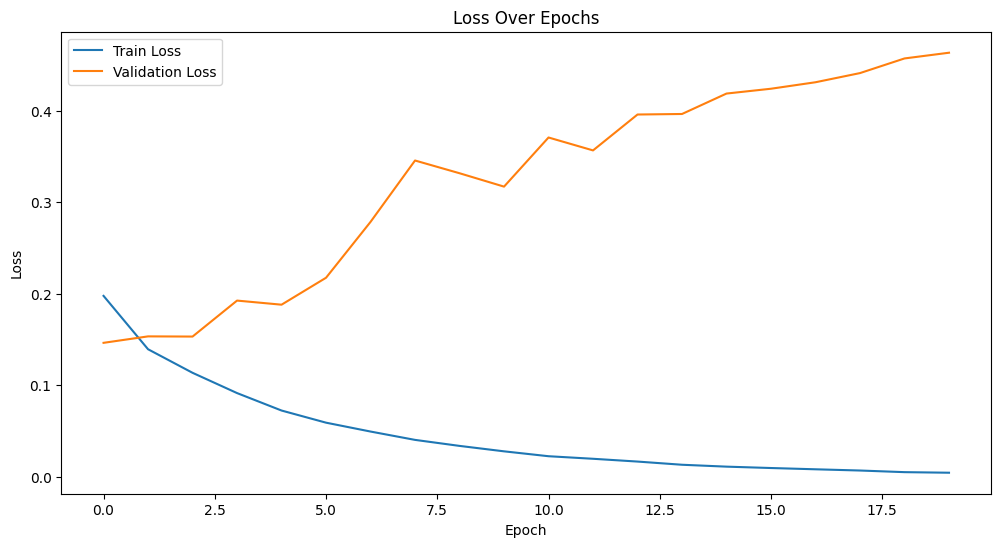

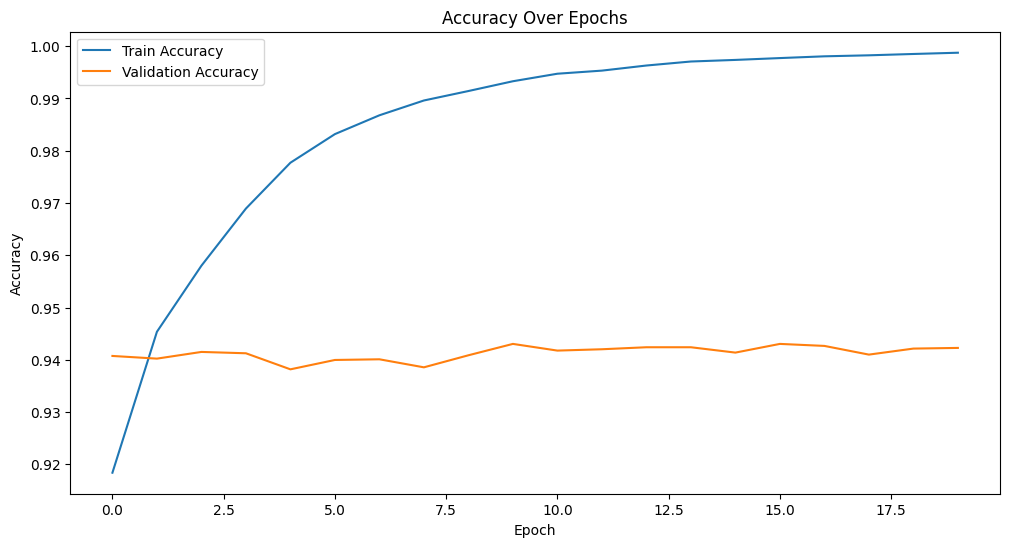

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()


Test Loss: 0.50
Test Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78      1072
    Positive       0.96      0.96      0.96      6741

    accuracy                           0.94      7813
   macro avg       0.87      0.87      0.87      7813
weighted avg       0.94      0.94      0.94      7813



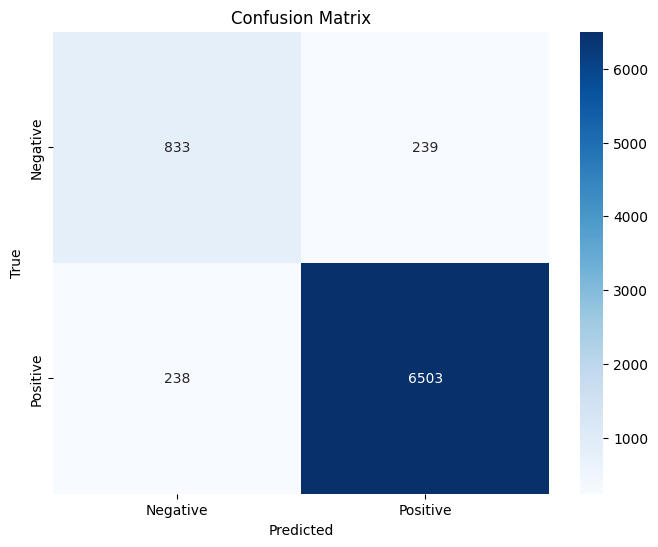

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = evaluate_loss_accuracy(model, test_dataloader, device)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

test_preds, test_labels = [], []
model.eval()

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        test_preds.extend(preds)
        test_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=["Negative", "Positive"]))

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


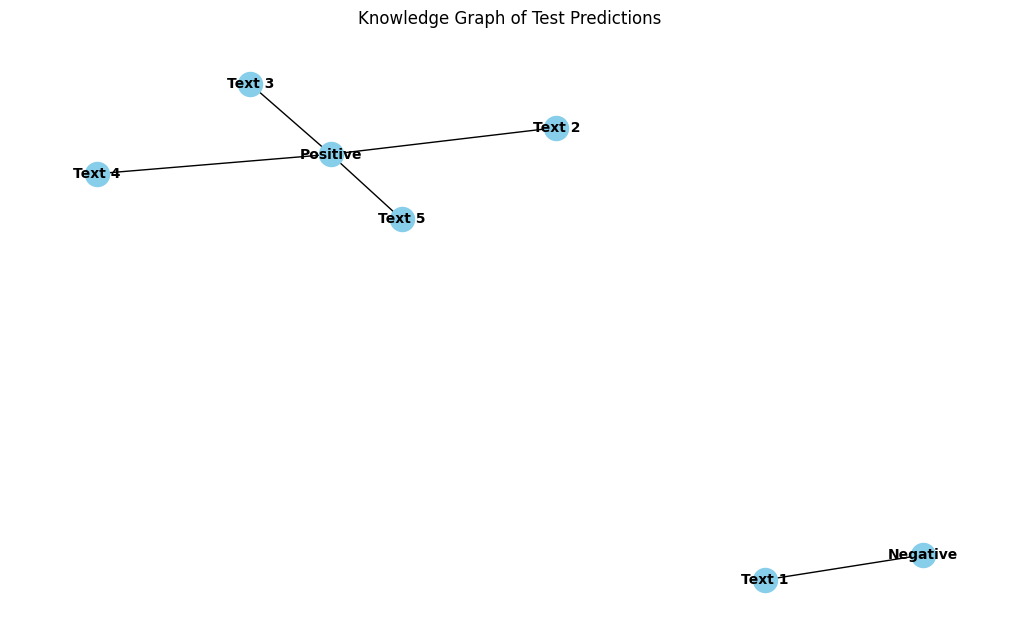

In [8]:
import networkx as nx
test_text = data['Combined'][:5]
G = nx.Graph()

for idx, text in enumerate(test_text):
    sentiment = "Positive" if test_preds[idx] == 1 else "Negative"
    G.add_node(f"Text {idx+1}", sentiment=sentiment)
    G.add_edge(f"Text {idx+1}", sentiment)

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color="skyblue", font_size=10, font_weight="bold")
plt.title("Knowledge Graph of Test Predictions")
plt.show()
